In [1]:
# from google.colab import drive
 
# drive.mount('/content/drive')

In [1]:
!python --version

Python 3.8.8


In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import PIL
from PIL import Image,UnidentifiedImageError,ImageFile

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
import cv2 as cv

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation
from keras.models import save_model,load_model
from keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.4.1


In [3]:
Image.MAX_IMAGE_PIXELS = 933120000
IMG_SIZE = (120,120)
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# DATASET PATHS
DATASET_DIR = Path('NEW_DATASET_10')

In [5]:
# Setting Up Directories

# TRAIN DATA PATH
TRAIN_CSV_PATH = os.path.join(DATASET_DIR,'TRAIN','multimodal_train.csv')
TRAIN_IMG_PATH = os.path.join(DATASET_DIR,'TRAIN','IMAGES')

# TEST DATA PATH
TEST_CSV_PATH = os.path.join(DATASET_DIR,'TEST','multimodal_test.csv')
TEST_IMG_PATH = os.path.join(DATASET_DIR,'TEST','IMAGES')

# VALIDATE DATA PATH
VALIDATE_CSV_PATH = os.path.join(DATASET_DIR,'VALIDATE','multimodal_validate.csv')
VALIDATE_IMG_PATH = os.path.join(DATASET_DIR,'VALIDATE','IMAGES')

# Model Outputs
MODEL_OUTPUT_DIR = Path('Model_Outputs')

In [6]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
validate_df = pd.read_csv(VALIDATE_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

In [7]:
def _isImgCorrupted(img):
    try:
        im = Image.open(img)
        im.verify()
        return False
 
    except FileNotFoundError:
        return True
    
    except SyntaxError:
        return True
    
    except PIL.UnidentifiedImageError:
        return True

In [8]:
def check_remove_corrupted_images(df,IMG_PATH):
    corruptCount = 0
    temp_df = df[['id','2_way_label']]
    for i,row in temp_df.iterrows():
        img,_ = row.tolist()
        impath = os.path.join(IMG_PATH,f'{img}.jpg')
        try:
            if _isImgCorrupted(impath):
                print(i,img)
                df = df.drop(i)
                corruptCount += 1
        
        except Exception as e:
            print(f'Error in {img} : {e}')
            # sys.exit(0)
    print(f'Removed {corruptCount} corrupted images.')
    return df

In [9]:
train_df = shuffle(train_df)
test_df = shuffle(test_df)
validate_df = shuffle(validate_df)

In [10]:
train_df = check_remove_corrupted_images(train_df,TRAIN_IMG_PATH)
test_df = check_remove_corrupted_images(test_df,TEST_IMG_PATH)
validate_df = check_remove_corrupted_images(validate_df,VALIDATE_IMG_PATH)

32504 c82xgjo
39432 f3snfue
30400 f3704pg
52462 cfgh9p6
33653 drslqwx
55192 ddj7mjf
56321 e5a0irs
36180 c9t9efu
37920 dcp93kl
52854 chmlqm2
36300 corzta4
56044 c76o894
33348 d0z4kl2
49288 csb9lwl
43944 ds6txmd
39597 cmcpahb
31102 cbyr0zz
48146 euf4y6i
43659 d0t4oap
48604 c89m77i
36063 f2zd5yw
37369 cafzidr
39277 dsqptd5
51152 cdekcw4
36040 dn406w7
49619 c4uolqt
48986 ca9ko4d
37981 c8uqsjg
35840 cqh3dwe
45643 c5qkhy6
34859 csjp1ca
36308 cm2petz
39220 cn6693m
42369 cea9g9y
37428 c8frys7
56150 dhig0jf
Removed 36 corrupted images.
4711 c7nbduy
4646 dhmh8hc
4123 cac53b8
Removed 3 corrupted images.
3018 cmk2pxb
5084 ctlphvf
3808 c89rc9d
Removed 3 corrupted images.


In [11]:
train_df.to_csv('train_csv.csv')
test_df.to_csv('test_csv.csv')
validate_df.to_csv('validate_csv.csv')

In [12]:
def append_ext(fn):
    return fn+".jpg"
train_df["id"]=train_df["id"].apply(append_ext)
validate_df["id"]=validate_df["id"].apply(append_ext)
test_df['id']=test_df['id'].apply(append_ext)

In [13]:
train_df[['id','2_way_label']].head()

,id,2_way_label
32832,c6tax3f.jpg,0
1020,c9zj2k.jpg,1
35896,cmc47lj.jpg,0
15882,cb6tk8.jpg,1
22894,c8iq13.jpg,1


In [14]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=50,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.3)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMG_PATH,
    x_col='id',
    y_col='2_way_label',
    class_mode='raw',
    target_size=IMG_SIZE,
    batch_size=32
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory=VALIDATE_IMG_PATH,
    x_col='id',
    y_col='2_way_label',
    class_mode='raw',
    target_size=IMG_SIZE,
    batch_size=32
)

Found 56364 validated image filenames.
Found 5931 validated image filenames.


## Model Building

### Without retraining or finetuning ResNet50

In [15]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

In [16]:
resnet = ResNet50(include_top=False, weights='imagenet',input_shape=(120,120,3))

output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)

resnet = Model(resnet.input,output)

for layer in resnet.layers:
    layer.trainable = False

resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 60, 60, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
from keras.utils import plot_model

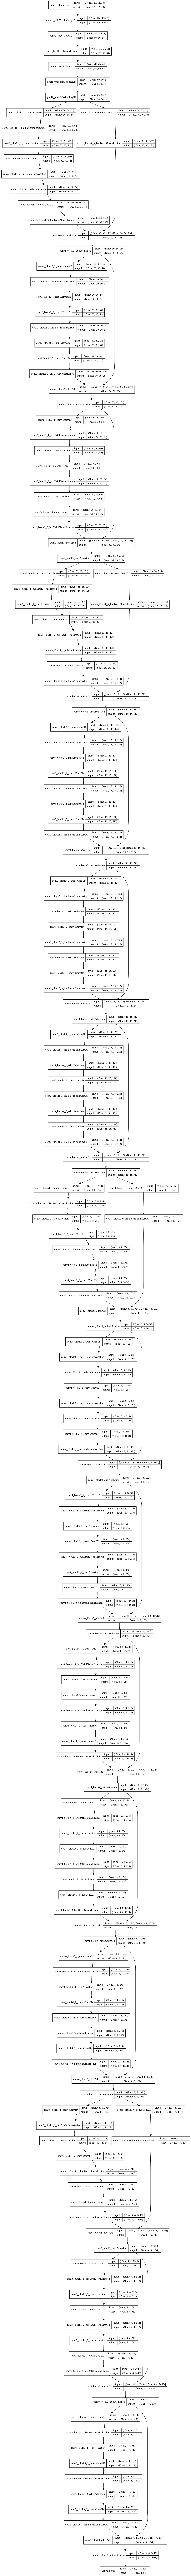

In [18]:
plot_model(resnet,show_shapes=True,show_layer_names=True)

In [19]:
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

In [20]:
model = Sequential()

model.add(resnet)
model.add(Dense(512,activation='relu',input_dim=(120,120,3)))
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(lr=1e-3),
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 32768)             23587712  
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 40,628,609
Trainable params: 17,040,897
Non-trainable params: 23,587,712
___________________________________

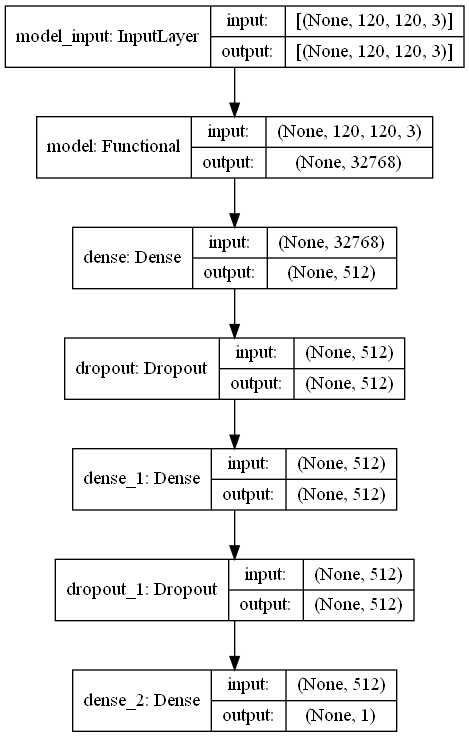

In [21]:
plot_model(model,show_shapes=True,show_layer_names=True)

In [25]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALIDATE = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALIDATE,
                    epochs=10)

Epoch 1/10
1761/1761 [==============================] - 751s 426ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 2/10
1761/1761 [==============================] - 1006s 571ms/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6930 - val_accuracy: 0.4997
Epoch 3/10
1761/1761 [==============================] - 788s 447ms/step - loss: 0.6933 - accuracy: 0.4977 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 4/10
1761/1761 [==============================] - 550s 312ms/step - loss: 0.6934 - accuracy: 0.5009 - val_loss: 0.6929 - val_accuracy: 0.4998
Epoch 5/10
1761/1761 [==============================] - 574s 326ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6929 - val_accuracy: 0.5005
Epoch 6/10
1761/1761 [==============================] - 759s 431ms/step - loss: 0.6935 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 7/10
1259/1761 [====================>.........] - ETA: 2:41 - loss: 0.6930 - accuracy: 0.5054

KeyboardInterrupt: 

In [ ]:
model.save('fake_news_img_classification_cnn_resnet_50.h5')

In [ ]:
# Model Outputs

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Fine-Tuning the pre-trained models

In [ ]:
resnet.trainable = True

set_trainable = False

for layer in resnet.layers:
    if layer.name in ['res5c_branch2b','res5c_branch2c','activation_97']:
        set_trainable = True
    if set_trainable = True:
        layer.trainable = True
    else:
        layer.trainable = False